In [2]:
!pip install transformers

In [3]:
!pip install huggingface_hub

In [4]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227141 sha256=1c1bc90fb65c8f9013d0da9e19a40d16cc55070a8857393fc91fb34acda55dcb
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [5]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [8]:
import glob
import pandas as pd
import csv
import re
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel, AdamW
import torch

import fasttext
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas as pd
import json

# Load Romanian BERT tokenizer

In [9]:
# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/397k [00:00<?, ?B/s]

# Utils

In [10]:
df_train = pd.read_csv("train.csv")
df_validation = pd.read_csv("validation.csv")
df_test = pd.read_csv("test.csv")

In [11]:
# Get the lists of contents and their labels.
### TRAIN ###
contents_train = df_train.full_text.values
labels_train = df_train.label.values


### VALIDATION ###
contents_validation = df_validation.full_text.values
labels_validation = df_validation.label.values

### TEST ###
contents_test = df_test.full_text.values
labels_test = df_test.label.values

In [ ]:
print("TRAIN")
# Print the original sentence.
print(' Original: ', contents_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_train[0])))

print("VALIDATION")
# Print the original sentence.
print(' Original: ', contents_validation[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_validation[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_validation[0])))

print("TEST")
# Print the original sentence.
print(' Original: ', contents_test[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(contents_test[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(contents_test[0])))

TRAIN
 Original:  Povestea continua. 
Tokenized:  ['Povestea', 'continua', '.']
Token IDs:  [10508, 4293, 18]
VALIDATION
 Original:  Ma poate ajuta cineva sa imi recuperez contul de facebook? Aveam mail pe ymail. Am incercat toate variantele officials pana acum fara succes. multumesc!. *oficiale
Tokenized:  ['Ma', 'poate', 'ajuta', 'cineva', 'sa', 'imi', 'recuper', '##ez', 'contul', 'de', 'facebook', '?', 'Aveam', 'mail', 'pe', 'y', '##mail', '.', 'Am', 'incercat', 'toate', 'variantele', 'official', '##s', 'pana', 'acum', 'fara', 'succes', '.', 'multumesc', '!', '.', '*', 'oficiale']
Token IDs:  [704, 647, 2548, 1925, 446, 5829, 20432, 5648, 6901, 363, 13767, 35, 13566, 5301, 376, 93, 7589, 18, 788, 17909, 765, 27266, 35742, 214, 4129, 889, 4255, 2715, 18, 12764, 5, 18, 14, 7698]
TEST
 Original:  ReporterIS - Adomniței are de 6 luni amânări la sentința definitivă, în pragul prescripției. Este nașul judecătorului CCR Gheorghe Stan. 
Tokenized:  ['Reporter', '##IS', '-', 'Ado', '##mni', 

## Tokenize dataset

### Train

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []
attention_masks_train = []

# For every webpage content.
for content in contents_train:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_train.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_train[0])
print('Token IDs:', input_ids_train[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Povestea continua. 
Token IDs: tensor([    2, 10508,  4293,    18,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


### Validation

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_validation = []
attention_masks_validation = []

# For every webpage content.
for content in contents_validation:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_validation.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_validation.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_validation = torch.cat(input_ids_validation, dim=0)
attention_masks_validation = torch.cat(attention_masks_validation, dim=0)
labels_validation = torch.tensor(labels_validation)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_validation[0])
print('Token IDs:', input_ids_validation[0])

Original:  Ma poate ajuta cineva sa imi recuperez contul de facebook? Aveam mail pe ymail. Am incercat toate variantele officials pana acum fara succes. multumesc!. *oficiale
Token IDs: tensor([    2,   704,   647,  2548,  1925,   446,  5829, 20432,  5648,  6901,
          363, 13767,    35, 13566,  5301,   376,    93,  7589,    18,   788,
        17909,   765, 27266, 35742,   214,  4129,   889,  4255,  2715,    18,
        12764,     5,    18,    14,  7698,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0

### Test

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every webpage content.
for content in contents_test:
    encoded_dict = tokenizer.encode_plus(
                        content,                   # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids_test.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Print sentence 0, now as a list of IDs.
print('Original: ', contents_test[0])
print('Token IDs:', input_ids_test[0])

Original:  ReporterIS - Adomniței are de 6 luni amânări la sentința definitivă, în pragul prescripției. Este nașul judecătorului CCR Gheorghe Stan. 
Token IDs: tensor([    2, 30716,  4665,    17,  6680, 35353,  1007,   711,   363,    26,
         1512, 27332,   362,   392, 20555, 12771,    16,   372, 10422, 26180,
          215,    18,  1080, 34867,   364, 27545, 14196,  3664,  7013,    18,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

# Train model

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
validation_dataset = TensorDataset(input_ids_validation, attention_masks_validation, labels_validation)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            num_workers=0
        )

validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = RandomSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size, num_workers=0 # Evaluate with this batch size.
        )

test_dataloader = DataLoader(test_dataset,
                             sampler=SequentialSampler(test_dataset),
                             batch_size=batch_size)

In [ ]:
class CustomBERTModel(torch.nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
          self.linear = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        sequence_output = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        bow = sequence_output[0].sum(1)
        linear = self.linear(bow)
        return linear


In [ ]:
model = CustomBERTModel()

# Tell pytorch to run this model on the GPU.
model.cuda()

CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-7, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def compute_metrics(y_pred, y_true):
  y_pred = np.argmax(y_pred, axis=1).flatten()
  macro_f1 = f1_score(y_true, y_pred, average='macro')
  # Popular - label 1
  TP_pop = 0 # y_true = 1 si y_pred = 1
  FP_pop = 0 # y_true = 0 si y_pred = 1
  FN_pop = 0 # y_true = 1 si y_pred = 0
  # Unpopular - label 0
  TP_unpop = 0 # y_true = 0 si y_pred = 0
  FP_unpop = 0 # y_true = 1 si y_pred = 0
  FN_unpop = 0 # y_true = 0 si y_pred = 1
  n = len(y_pred)
  for index in range(n):
    # Popular
    if y_true[index] == 1:
      if y_pred[index] == 1:
        TP_pop += 1
      if y_pred[index] == 0:
        FN_pop += 1
        FP_unpop += 1
    else:
    # Unpopular y_true[index] == 0
      if y_pred[index] == 0:
        TP_unpop += 1
      if y_pred[index] == 1:
        FN_unpop += 1
        FP_pop += 1

  P_pop = 0 if TP_pop + FP_pop == 0 else TP_pop / (TP_pop + FP_pop)
  R_pop = 0 if TP_pop + FN_pop == 0 else TP_pop / (TP_pop + FN_pop)
  P_unpop = 0 if TP_unpop + FP_unpop == 0 else TP_unpop / (TP_unpop + FP_unpop)
  R_unpop = 0 if TP_unpop + FN_unpop == 0 else TP_unpop / (TP_unpop + FN_unpop)

  return (macro_f1, P_pop, R_pop, P_unpop, R_unpop)

In [ ]:
import random
import numpy as np
import os

seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

criterion = torch.nn.CrossEntropyLoss() ## If required define your own criterion


# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # print(batch[0])
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask)
        outputs = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, b_labels)

        total_train_loss += loss.item()


        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    total_eval_p_pop = 0
    total_eval_r_pop = 0
    total_eval_p_unpop = 0
    total_eval_r_unpop = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        outputs = torch.nn.functional.log_softmax(outputs, dim=1)

        loss = criterion(outputs, b_labels)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        predicted_labels = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(predicted_labels, label_ids)
        (f1, p_pop, r_pop, p_unpop, r_unpop) = compute_metrics(predicted_labels, label_ids)
        total_eval_f1 += f1
        total_eval_p_pop += p_pop
        total_eval_p_unpop += p_unpop
        total_eval_r_pop += r_pop
        total_eval_r_unpop += r_unpop
    # Calculate the average loss over all of the batches.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    avg_val_p_pop = total_eval_p_pop / len(validation_dataloader)
    avg_val_r_pop = total_eval_r_pop / len(validation_dataloader)
    avg_val_p_unpop = total_eval_p_unpop / len(validation_dataloader)
    avg_val_r_unpop = total_eval_r_unpop / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Macro F1: {0:.4f}".format(avg_val_f1))
    print("  Precision popular: {0:.4f}".format(avg_val_p_pop))
    print("  Recall popular: {0:.4f}".format(avg_val_r_pop))
    print("  Precision unpopular: {0:.4f}".format(avg_val_p_unpop))
    print("  Recall unpopular: {0:.4f}".format(avg_val_r_unpop))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Acc.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    739.    Elapsed: 0:00:08.
  Batch    80  of    739.    Elapsed: 0:00:16.
  Batch   120  of    739.    Elapsed: 0:00:24.
  Batch   160  of    739.    Elapsed: 0:00:33.
  Batch   200  of    739.    Elapsed: 0:00:41.
  Batch   240  of    739.    Elapsed: 0:00:49.
  Batch   280  of    739.    Elapsed: 0:00:57.
  Batch   320  of    739.    Elapsed: 0:01:05.
  Batch   360  of    739.    Elapsed: 0:01:13.
  Batch   400  of    739.    Elapsed: 0:01:21.
  Batch   440  of    739.    Elapsed: 0:01:29.
  Batch   480  of    739.    Elapsed: 0:01:37.
  Batch   520  of    739.    Elapsed: 0:01:45.
  Batch   560  of    739.    Elapsed: 0:01:53.
  Batch   600  of    739.    Elapsed: 0:02:01.
  Batch   640  of    739.    Elapsed: 0:02:09.
  Batch   680  of    739.    Elapsed: 0:02:17.
  Batch   720  of    739.    Elapsed: 0:02:26.

  Average training loss: 5.2512
  Training epoch took: 0:02:29

Running Validation...
  Accuracy: 0.5854
  Va

In [ ]:
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Acc.,Training Time,Validation Time
epoch,,,,,
1,5.251228,2.408146,0.585354,0:02:29,0:00:04
2,2.214150,1.717782,0.606343,0:02:29,0:00:04
3,1.696446,1.572956,0.584888,0:02:29,0:00:04
4,1.495859,1.339399,0.636194,0:02:29,0:00:04
5,1.387221,1.401931,0.594683,0:02:29,0:00:04
6,1.293110,1.250407,0.621735,0:02:29,0:00:04
7,1.229774,1.314502,0.597015,0:02:29,0:00:04
8,1.201285,1.212796,0.604011,0:02:29,0:00:04
9,1.155479,1.202077,0.607743,0:02:29,0:00:04


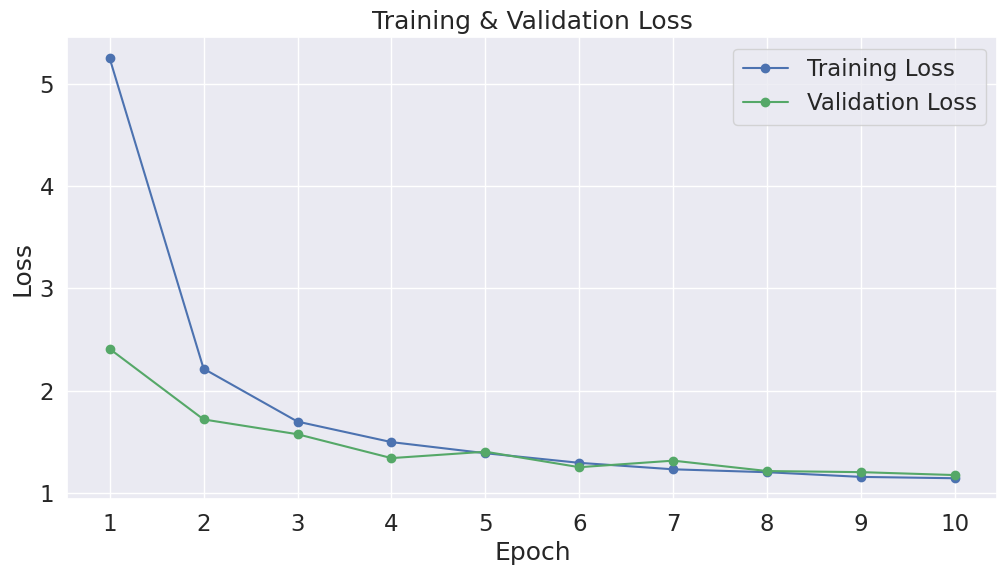

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()

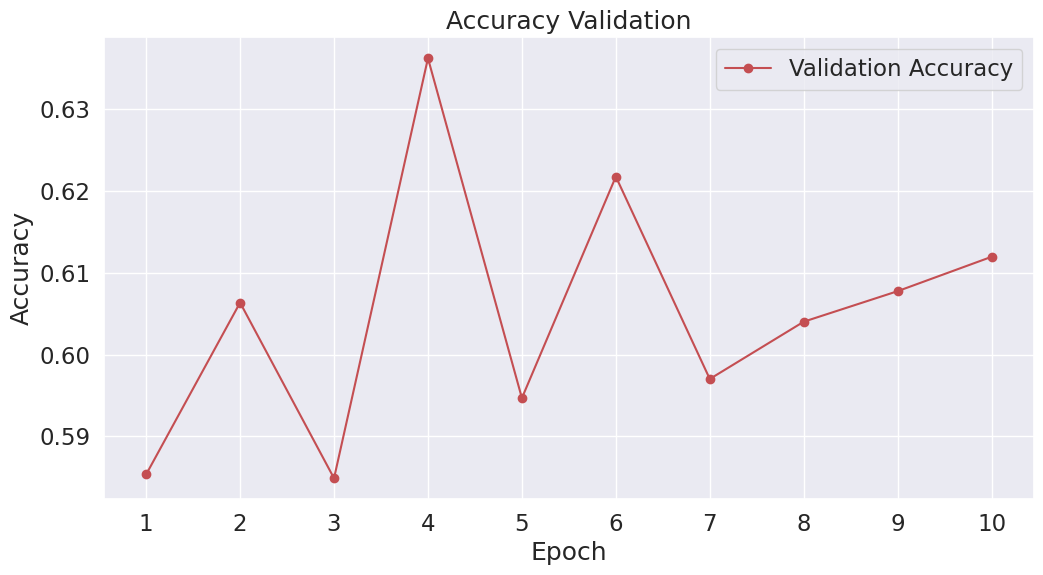

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Valid. Acc.'], 'r-o', label="Validation Accuracy")
# Label the plot.
plt.title("Accuracy Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()

## 5.2. Evaluate on Test Set


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

total_loss = 0
# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    outputs = model(b_input_ids, attention_mask=b_input_mask)

  outputs = torch.nn.functional.log_softmax(outputs, dim=1)
  # Move logits and labels to CPU
  predicted_labels = outputs.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(predicted_labels)
  true_labels.append(label_ids)
  loss = criterion(outputs, b_labels)
  total_loss += loss.item()

print('    DONE.')
print("  Test Loss: {0:.4f}".format(total_loss/len(test_dataloader)))

Predicting labels for 2,349 test sentences...
    DONE.
  Test Loss: 1.3899


In [ ]:
sum_accuracy = 0
total_test_f1 = 0
total_test_p_pop = 0
total_test_r_pop = 0
total_test_p_unpop = 0
total_test_r_unpop = 0


print(len(predictions))
for index in range(len(predictions)):
  (f1, p_pop, r_pop, p_unpop, r_unpop) = compute_metrics(predictions[index], true_labels[index])
  total_test_f1 += f1
  total_test_p_pop += p_pop
  total_test_p_unpop += p_unpop
  total_test_r_pop += r_pop
  total_test_r_unpop += r_unpop
  curr_acc = flat_accuracy(predictions[index], true_labels[index])
  sum_accuracy += curr_acc

74


In [ ]:
avg_test_accuracy = sum_accuracy / len(predictions)
avg_test_f1 = total_test_f1 / len(predictions)
avg_test_p_pop = total_test_p_pop / len(predictions)
avg_test_r_pop = total_test_r_pop / len(predictions)
avg_test_p_unpop = total_test_p_unpop / len(predictions)
avg_test_r_unpop = total_test_r_unpop / len(predictions)
print("  Accuracy: {0:.4f}".format(avg_test_accuracy))
print("  Macro F1: {0:.4f}".format(avg_test_f1))
print("  Precision popular: {0:.4f}".format(avg_test_p_pop))
print("  Recall popular: {0:.4f}".format(avg_test_r_pop))
print("  Precision unpopular: {0:.4f}".format(avg_test_p_unpop))
print("  Recall unpopular: {0:.4f}".format(avg_test_r_unpop))

  Accuracy: 0.5423
  Macro F1: 0.5323
  Precision popular: 0.5388
  Recall popular: 0.5760
  Precision unpopular: 0.5408
  Recall unpopular: 0.5048


In [ ]:
!pip install captum

In [ ]:
model.to('cpu')
model.eval()
model.zero_grad()

In [ ]:
# Define model output
def model_output(inputs):
  outputs = model(inputs)
  # return torch.nn.functional.log_softmax(outputs[0], dim=1)
  return outputs[0]

# Define model input
model_input = model.bert.embeddings

In [ ]:
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz

lig = LayerIntegratedGradients(model_output, model_input)

In [ ]:
def construct_input_and_baseline(text):

    max_length = 120
    baseline_token_id = tokenizer.pad_token_id
    sep_token_id = tokenizer.sep_token_id
    cls_token_id = tokenizer.cls_token_id

    text_ids = tokenizer.encode(text, max_length=max_length, truncation=True, add_special_tokens=False)

    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = tokenizer.convert_ids_to_tokens(input_ids)

    baseline_input_ids = [cls_token_id] + [baseline_token_id] * len(text_ids) + [sep_token_id]
    return torch.tensor([input_ids], device='cpu'), torch.tensor([baseline_input_ids], device='cpu'), token_list


In [ ]:
def summarize_attributions(attributions):

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)

    return attributions

In [ ]:
for index in range(100):
  input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(contents_test[index])
  attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=baseline_input_ids,
                                    return_convergence_delta=True,
                                    internal_batch_size=1
                                    )
  attributions_sum = summarize_attributions(attributions)


  score_vis = viz.VisualizationDataRecord(
                          word_attributions = attributions_sum,
                          pred_prob = torch.max(model(input_ids)[0]),
                          pred_class = torch.argmax(model(input_ids)[0]).numpy(),
                          true_class = contents_test[index],
                          attr_class = labels_test[index],
                          attr_score = attributions_sum.sum(),
                          raw_input_ids = all_tokens,
                          convergence_score = delta)

  viz.visualize_text([score_vis])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Ieșenii s-au rugat pentru autostrăzi în Moldova și pentru a scăpa de primarul Mihai Chirica.,0 (4.13),0,3.28,[CLS] Ie ##șenii s - au rugat pentru autostrăzi în Moldova și pentru a scăpa de primarul Mihai Chirica . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Ati supraviețuit?. Eu n-am mai vazut asa furtuna sincer:)),0 (1.04),1,1.37,[CLS] Ati supraviețuit ? . Eu n - am mai vazut asa furtuna sincer : ) ) [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Uite ca se poate!!!.,0 (0.89),1,0.06,[CLS] Uite ca se poate ! ! ! . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Street art în Timișoara.,0 (1.13),0,1.09,[CLS] Street art în Timișoara . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Un pic de furtuna.,0 (1.32),1,1.18,[CLS] Un pic de furtuna . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"British International School of Timișoara ridică o nouă clădire, cu o investiție de șase milioane de euro/FOTO.",0 (4.35),0,2.95,"[CLS] British International School of Timișoara ridică o nouă clădire , cu o investiție de șase milioane de euro / FOTO . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Primăria Cluj obligată să plătească 7,3 milioane de euro pentru că a interzis mall-ul de lângă Expo Transilvania.",0 (6.57),0,3.45,"[CLS] Primăria Cluj obligată să plătească 7 , 3 milioane de euro pentru că a interzis mall - ul de lângă Expo Transilvania . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Teatrul Național „Vasile Alecsandri” din Iași.,0 (1.46),1,1.99,[CLS] Teatrul Național „ Vasile Alecsandri ” din Iași . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"O plimbare prin Cluj Napoca mereu dezvaluie cadre noi, mai simple sau mai complexe.",1 (4.23),1,2.66,"[CLS] O plimbare prin Cluj Napoca mereu dezval ##uie cadre noi , mai simple sau mai complexe . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
O pierdere: apeductul de la Ciric.,0 (1.91),0,1.63,[CLS] O pierdere : ape ##duc ##tul de la Cir ##ic . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Unde găsesc terenuri ok de baschet prin Timișoara??.,0 (1.19),0,1.58,[CLS] Unde găsesc terenuri ok de baschet prin Timișoara ? ? . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Tot Centrul Iașului e plin de terase din lemn tip „iesle de oi”, făcute cu încălcarea PUG.",0 (7.84),1,2.42,"[CLS] Tot Centrul Iașului e plin de terase din lemn tip „ ies ##le de oi ” , făcute cu încălcarea PU ##G . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Ghid, pentru cei care vor să se implice activ în comunitatea lor. - via politicalaminut.",1 (2.10),1,2.01,"[CLS] Ghid , pentru cei care vor să se implice activ în comunitatea lor . - via politica ##lam ##inu ##t . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Bulevardul Carol, Iași.",0 (2.37),1,1.30,"[CLS] Bulevardul Carol , Iași . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Iași anii '70 - Iliescu și Ceaușescu.,0 (0.76),0,-0.00,[CLS] Iași anii ' 70 - Iliescu și Ceaușescu . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Colecție de fotografii cu cartierul Gheorgheni din anii '60.,0 (1.02),0,0.40,[CLS] Cole ##cție de fotografii cu cartierul Gheorghe ##ni din anii ' 60 . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Conflictele din prima săptămână LGBT care a avut loc vreodată în Timișoara.,0 (1.89),0,1.25,[CLS] Conflic ##tele din prima săptămână LGBT care a avut loc vreodată în Timișoara . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Școala Babel, din septembrie 2022 în Timișoara.",0 (3.45),0,1.83,"[CLS] Școala Babe ##l , din septembrie 2022 în Timișoara . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"târguri de chilipiruri. Exista târguri de vechituri in iasi?daca da ,in ce zona?",0 (1.84),0,1.48,"[CLS] târguri de chil ##ip ##ir ##uri . Exista târguri de vechi ##turi in ia ##si ? daca da , in ce zona ? [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Harta imobilelor din județul Iași expertizate la riscul seismic.,0 (1.69),1,1.56,[CLS] Harta imobilelor din județul Iași expertiza ##te la riscul seism ##ic . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Clujul, pustiu în lipsa elevilor. Nici țipenie de om, dimineața la 7, în cartierele clujene. FOTO.",1 (2.82),1,2.39,"[CLS] Clujul , pustiu în lipsa elevilor . Nici țipe ##nie de om , dimineața la 7 , în cartierele clujene . FOTO . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Second Hand uri mai faine? Sau sugestii dacă aveți..,0 (2.41),0,1.09,[CLS] Sec ##ond Hand uri mai faine ? Sau sugestii dacă aveți . . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Se închide circulația pe bulevardul Eroilor de la Tisa.,0 (3.34),0,2.22,[CLS] Se închide circulația pe bulevardul Eroilor de la Tisa . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
In interiorul fostei fabrici de palarii..,0 (0.89),1,0.48,[CLS] In interiorul fostei fabrici de pala ##rii . . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Harta Moldovei în 1595.,1 (0.50),1,0.52,[CLS] Harta Moldovei în 159 ##5 . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Adulții nu mai au acces pe terenurile de sport ale şcolilor.,1 (4.07),0,2.64,[CLS] Adulți ##i nu mai au acces pe terenurile de sport ale [UNK] . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Palatul Roznovanu (Primaria Municipiului Iasi) martie 2023.,0 (2.67),1,2.17,[CLS] Palatul Roz ##nov ##anu ( Primaria Municipiului Iasi ) martie 202 ##3 . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"No, amu ce arde iara ?.",1 (-1.05),1,-0.64,"[CLS] No , am ##u ce arde iar ##a ? . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Avem colegi de subreddit care ar fi interesati de un voluntariat si carora le place sa lucreze cu copiii?.,1 (4.31),0,2.95,[CLS] Avem colegi de sub ##red ##dit care ar fi interesati de un voluntariat si carora le place sa lucreze cu copiii ? . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Ceva titlu.,0 (1.01),1,1.46,[CLS] Ceva titlu . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Liftarea acoperişului la cinematograful Copou din Iaşi - 1969.,0 (1.31),1,1.43,[CLS] Li ##fta ##rea [UNK] la cinematograf ##ul Copou din [UNK] - 1969 . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Propunere de corectie a chiriilor in Cluj.,0 (0.16),0,0.05,[CLS] Propunere de corect ##ie a chiri ##ilor in Cluj . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Ce bine că nu se plătește parcarea și nu se ridică mașini pe Marinescu 🤡. Mergem pe gard..,1 (2.23),0,2.11,[CLS] Ce bine că nu se plătește parcarea și nu se ridică mașini pe Marinescu [UNK] . Mergem pe gard . . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Tătărași - In sfârșit a nins.,0 (1.84),1,1.35,[CLS] Tătă ##rași - In sfârșit a nins . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Copilărie în leagăn 🤗.,0 (0.67),1,0.11,[CLS] Copilă ##rie în leagăn [UNK] . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Primarul Chirica, noaptea și ziua - sursa JUP.",0 (2.33),1,2.09,"[CLS] Primarul Chirica , noaptea și ziua - sursa JU ##P . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Timisoara, Romania.",0 (0.94),1,0.84,"[CLS] Timisoara , Romania . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Doar eu simt că aerul miroase atât de rău încât nu pot sa deschid geamul? (zona Palas).,0 (2.35),1,1.26,[CLS] Doar eu simt că aerul miroase atât de rău încât nu pot sa deschid geamul ? ( zona Palas ) . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
"Un nou residence la ""doar 20 de minute"" de Centru cu masina, noaptea si fara semafoare.",1 (5.59),1,3.15,"[CLS] Un nou res ##iden ##ce la "" doar 20 de minute "" de Centru cu masina , noaptea si fara semaf ##oare . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Timisoara - Libertatii (23/01/2021@17:51).,0 (2.42),1,1.66,[CLS] Timisoara - Liber ##tatii ( 23 / 01 / 2021 @ 17 : 51 ) . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Evenimente Iași 2023 - via Destination IAȘI.,0 (1.29),1,1.03,[CLS] Evenimente Iași 202 ##3 - via Destin ##ation IA ##ȘI . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Vloggeri canadieni prezentând Iașiul.,0 (2.84),1,1.99,[CLS] V ##log ##geri cana ##dieni prezentând Iași ##ul . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Pe unde sa fie in Iasi ca eu nu-mi mai aduc aminte unde am facut poza....,0 (1.69),1,0.90,[CLS] Pe unde sa fie in Iasi ca eu nu - mi mai aduc aminte unde am facut poza . . . . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Mergi la cumpărături și faci și un duș.,1 (2.59),1,1.63,[CLS] Mergi la cumpărături și faci și un duș . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Pe 14 decembrie 1989 Iașul putea fi Timișoara.,0 (1.71),0,1.16,[CLS] Pe 14 decembrie 1989 Ia ##șul putea fi Timișoara . [SEP]
